In [5]:
#!/usr/bin/env python3
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
import time
import numpy as np
import math

In [6]:
# TASK
# Find the function DT(n) 
# DT = Tcal-T
try:
    Data = np.loadtxt("data.csv", dtype=np.str, delimiter=",")
    L_list=Data[1:,0].astype(np.float) #lable
    T_list=Data[1:,1].astype(np.float) #data T (temperture)
    R_list=Data[1:,2].astype(np.float) #data R
    #L = 2*(np.ones(len(L_list)))
    #print(L_list-L)
except:
    pritn("Load file faild!")
    sys.exit(0)

In [7]:
#--------------initial condition-----------
s = 1
l = 590         ##nm
d = 1.032699999

#--------------Tcal's parameters-----------
n = np.linspace(0.4, 1.8, len(L_list))

A = 16*s*(n**2)
B = (n+s**2)*(n+1)**3
C = 2*(n**2- 1)*(n**2-s**2)
D = (n-1)**3*(n-s**2)
x=(1-R_list)**2/T_list

DT = ((A*x)/(B-C*x*np.cos((4*math.pi*n*d)/(l)*(180/math.pi)*math.pow(10,-6))+D))-(T_list)
#print("length of n = %f" %len(n))
#print("length of DT = %f" %len(DT))

Text(0, 0.5, 'Tcal-T')

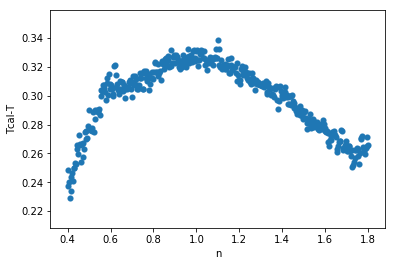

In [8]:
plt.scatter(n,DT, marker='o', lw=0.1,label='Tcal-T')
plt.xlabel('n')
plt.ylabel('Tcal-T')

In [9]:
#convert to usable data for pytorch
x = torch.unsqueeze(torch.from_numpy(n), dim=1).float()
y = torch.unsqueeze(torch.from_numpy(DT), dim=1).float()

plt.plot(x.data.numpy(), y.data.numpy(), 'r-', lw=2)

RuntimeError: cannot call .data on a torch.Tensor: did you intend to use autograd.Variable?

In [10]:
# torch.manual_seed(1)    # reproducible

#x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
#y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

#plt.plot(x.data.numpy(), y.data.numpy(), 'r-', lw=2)

In [11]:

# torch can only train on Variable, so convert them to Variable
# The code below is deprecated in Pytorch 0.4. Now, autograd directly supports tensors
# x, y = Variable(x), Variable(y)

# plt.scatter(x.data.numpy(), y.data.numpy())
# plt.show()


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x



In [13]:
net = Net(n_feature=1, n_hidden=24, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

plt.ion()   # something about plotting

for t in range(2000):
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    if t % 50 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)

plt.ioff()

Net(
  (hidden): Linear(in_features=1, out_features=24, bias=True)
  (predict): Linear(in_features=24, out_features=1, bias=True)
)


RuntimeError: addmm(): argument 'mat1' (position 1) must be Variable, not torch.FloatTensor